In [44]:
import numpy as np
import scipy as scp

import math
import multiprocessing 

In [45]:
def translate_p_s(t, group, other_clusters):
    return process_sillhouete(t[0], t[1], group, other_clusters)

def process_sillhouete(x_i, x_tuple, group, other_clusters):
    x_identifier, x = x_tuple['i'], x_tuple['x']
    group_without_x = np.delete(group, x_i, axis=0)
    average_intra_cluster_distance = np.mean([np.linalg.norm(x - y['x']) for y in group_without_x])

    neighbor_clusters_medium_distances= [np.mean([np.linalg.norm(x - y['x']) for y in neighbor]) for neighbor in other_clusters]
    min_average_extra_cluster_distance = np.amin(neighbor_clusters_medium_distances) if len(neighbor_clusters_medium_distances) > 0 else 0

    x_score = (min_average_extra_cluster_distance - average_intra_cluster_distance) / max(min_average_extra_cluster_distance, average_intra_cluster_distance)
    return x_identifier, x_score

def h(x):
    if np.all(np.array(x)==0):
        return np.array(x) + 1
    return np.array(x)

class KMeans():
    def __init__(self):
        self.centroids = []
        self.distance_function = None
        self.max_iterations = 0
        self.min_adjustment = 0
    
    
    def with_euclidian_distance(self):
        self.distance_function = lambda x, y: np.linalg.norm(np.array(x) - np.array(y), axis=0)
        return self
    
    def with_cosin_similarity(self):
        self.distance_function = lambda x, y: scp.spatial.distance.cosine(h(x), h(y))
        return self
    
    def set_max_iterations(self, iterations):
        self.max_iterations = iterations
        return self
    
    def set_min_adjustment(self, adjustment):
        self.min_adjustment = adjustment
        return self
    
    def initialize_random(self, centroid_number, data):
        data_count, dimensions = data.shape
        selected_rows = np.random.randint(0, data_count, centroid_number)
        self.centroids = data[selected_rows]
        return self
    
    def initialize_plus_plus(self, centroid_number, data):
        data_count, dimensions = data.shape
        self.centroids = [data[np.random.randint(0, data_count)]]
        
        for _ in range(centroid_number - 1):
            squared_distances_to_bmus = np.array([self.distance_function(x, self.get_bmu(x)[1]) ** 2 for x in data])
            probabilities = squared_distances_to_bmus / squared_distances_to_bmus.sum()
            probabilites_accumulated = probabilities.cumsum()
            
            r = np.random.random()
            ind = np.where(probabilites_accumulated >= r)[0][0]
            self.centroids.append(data[ind])
        return self

    def train(self, X):
        finished = False
        current_iteration = 0
        while not finished:
            adjustment = self.fit(X)
            current_iteration += 1
            if self.max_iterations > 0 and current_iteration > self.max_iterations:
                finished = True

            if adjustment <= self.min_adjustment:
                finished = True

        return self, current_iteration
    
    def predict(self, x):
        group_id, bmu = self.get_bmu(x)
        return group_id, bmu

    def get_bmu(self, x):
        bmu_id, bmu, bmu_dist = 0, self.centroids[0], self.distance_function(self.centroids[0], x)
        for i, c in enumerate(self.centroids[1:], 1):
            c_dist = self.distance_function(c, x)
            if c_dist < bmu_dist:
                bmu_id, bmu, bmu_dist = i, c, c_dist
        return bmu_id, bmu

    def fit(self, X):
        groups = [[] for i in self.centroids]
        for x in X:
            bmu_id, _ = self.get_bmu(x)
            groups[bmu_id].append(x)
        
        adjustment = 0
        for group_id, _ in enumerate(groups):
            group_mean = np.mean(groups[group_id], 0) if len(groups[group_id]) > 0 else None
            if group_mean is not None:
                adjustment += self.distance_function(self.centroids[group_id], group_mean)
                self.centroids[group_id] = group_mean
        
        self.groups = groups
        return adjustment
    
    def get_squared_mean_error(self, X):
        error = 0
        c = 0
        for x in X:
            error += self.distance_function(x, self.get_bmu(x)[1]) ** 2
            c += 1
        return error / c 
    
    def get_bic_score(self, X):
        data_count, dimensions = X.shape
        log_likelihood = self.get_log_likehood(data_count, dimensions, self.groups, self.centroids)
        
        num_free_params = len(self.groups) * (dimensions + 1)
        return log_likelihood - num_free_params / 2.0 * np.log(data_count)

    def get_log_likehood(self, data_count, dimensions, groups, centroids):
        ll = 0
        for group in groups:
            fRn = len(group)
            
            t1 = fRn * np.log(fRn)
            t2 = fRn * np.log(data_count)
            
            variance = max(self._cluster_variance(data_count, dimensions, groups, centroids), np.nextafter(0, 1))
            t3 = variance * (fRn * dimensions / 2.0) * np.log(2.0 * np.pi)
            t4 = (dimensions * (fRn - 1.0) / 2.0)
            ll += t1 - t2 - t3 - t4
                                                              
        return ll

    def _cluster_variance(self, data_count, dimensions, groups, centroids):
        s = 0
        for group, centroid in zip(groups, centroids):
            s += sum([self.distance_function(x, centroid) ** 2 for x in group])
        return s / float(data_count - len(centroids)) * dimensions
    
    def get_sillhouete_score(self, X):
        with multiprocessing.Pool(processes=5) as pool:
            self.groups = [[] for i in self.centroids]
            for i, x in enumerate(X):
                bmu_id, _ = self.get_bmu(x)
                self.groups[bmu_id].append({'i': i, 'x': x})

            indexes = []
            for i, group in enumerate(self.groups):
                other_clusters = np.delete(self.groups, i, axis=0)
                s = X.shape[0]
                s_group = pool.starmap(translate_p_s, zip(enumerate(group), [group for _ in range(s)], [other_clusters for _ in range(s)]))
                indexes.append(s_group)
            return indexes


In [46]:
import copy
class XMeans(KMeans):
    
    def create_k_means_copy(self):
        instance = KMeans()
        instance.centroids = copy.deepcopy(self.centroids)
        instance.distance_function = self.distance_function
        instance.max_iterations = self.max_iterations
        instance.min_adjustment = self.min_adjustment
        return instance
    
    def set_centroid_estimation_range(self, minimum, maximum):
        self.minimum = minimum
        self.maximum = maximum
        return self
    
    def train(self, X):
        self.initialize_plus_plus(self.minimum, X)

        super().train(X)
        
        k = 0
        while len(self.centroids) < self.maximum:
            old_len = len(self.centroids)
            self.centroids = self.plan_new_centroids(X)
            
            super().train(X)
            
            if len(self.centroids) == old_len:
                k += 1
            else:
                k = 0

            if k == 10:
                break
        return self, len(self.centroids)
    
    def plan_new_centroids(self, X):

        new_centroids = []
        for i, old_centroid in enumerate(self.centroids):
            if len(new_centroids) >= self.maximum - 1:
                break
                
            pre_split_kmeans = self.create_k_means_copy()
            hipotesis_kmeans = self.create_k_means_copy()
    
            x_in_centroid_group = np.array([x for x in X if hipotesis_kmeans.predict(x)[0] == i])
            
            pre_split_kmeans.centroids = [old_centroid]
            
            data_count, _ = x_in_centroid_group.shape
            delta_vector = x_in_centroid_group[np.random.randint(0, data_count)]
            
            hipotesis_kmeans.centroids = [delta_vector, 2 * np.array(old_centroid) - np.array(delta_vector)]
            
            pre_split_kmeans.train(x_in_centroid_group)
            hipotesis_kmeans.train(x_in_centroid_group)
            
            # Compare pre_split and post_split models
            if hipotesis_kmeans.get_bic_score(X) > pre_split_kmeans.get_bic_score(X):
                new_centroids += hipotesis_kmeans.centroids
            else:
                new_centroids += pre_split_kmeans.centroids
        return new_centroids

In [47]:
def read_data(path):
    x = np.genfromtxt(path, delimiter=',', skip_header=1)
    x = np.delete(x, 0, axis=1)
    return x

In [48]:
data = read_data('data/bbc/BsaidaBin98.csv')
data.shape

(737, 1369)

## Toy datasets

In [49]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from itertools import cycle, islice
%matplotlib inline
np.random.seed(555)
blobs = datasets.make_blobs(n_samples=50, centers=5)
#blobs = np.random.random((50, 2)) * 10, 1


X, y = blobs

def test_instance(instance, X=X, y=y):
    fig = plt.figure(figsize=(5, 5))
    predictions = [instance.predict(x) for x in X]
    y_pred = [y for y, _ in predictions]

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))

    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
    for i, centroid in enumerate(instance.centroids):
        square = plt.Rectangle(centroid, 0.21, 0.2, color='black')
        fig.gca().add_artist(square)

    sillhouetes = np.array([[i, val, g] for g, group in enumerate(instance.get_sillhouete_score(X)) for i, val in group ])
    fig, ax = plt.subplots()
    ax.barh(sillhouetes[:, 0].astype(str),sillhouetes[:, 1], align='center',
            color=colors[sillhouetes[:, 2].astype(int)], ecolor='black')
    #ax.set_yticks(y_pos)
    ax.set_yticklabels([])
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('S Score')
    ax.set_title('S Score')

    plt.show()

Trained in  5 iterations


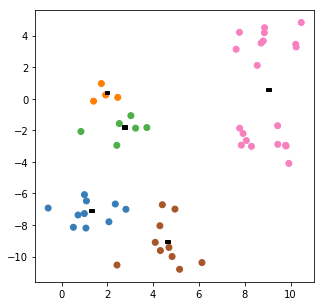

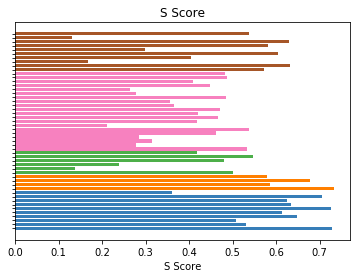

In [50]:

kmeans, iterations = KMeans() \
            .initialize_random(5, X) \
            .with_euclidian_distance() \
            .train(X)
            
print('Trained in ', iterations, 'iterations')
test_instance(kmeans)

Trained in  5 iterations


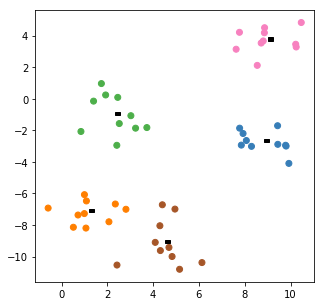

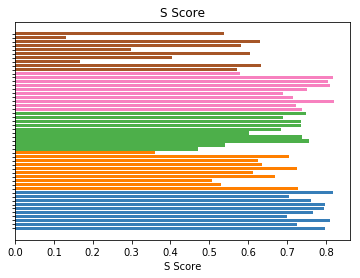

In [51]:
kmeans, iterations = KMeans() \
            .with_euclidian_distance() \
            .initialize_plus_plus(5, X) \
            .train(X)
            
print('Trained in ', iterations, 'iterations')
test_instance(kmeans)

Created 5 centroids


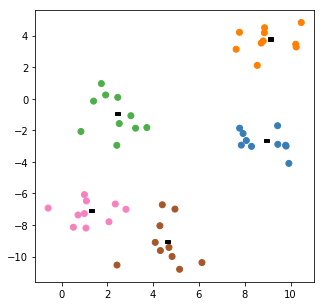

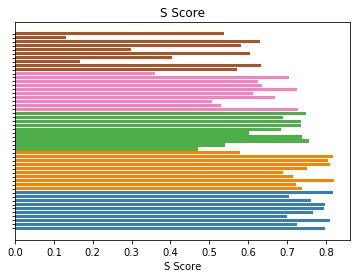

In [52]:

kmeans, iterations = XMeans() \
            .with_euclidian_distance() \
            .set_centroid_estimation_range(1, 5) \
            .train(X)
            
print('Created', iterations, 'centroids')
    
test_instance(kmeans)

In [53]:
kmeans.get_squared_mean_error(X)

1.7460214637081901

In [54]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from itertools import cycle, islice
%matplotlib inline


def plot_elbow(error_table):
    fig = plt.figure(figsize=(20, 20))

    fig, ax = plt.subplots()
    plt.scatter(error_table[:, 0].astype(str), error_table[:, 1], color='black')
    ax.set_title('Elbow Score')

    plt.show()

def plot_silhouette(instance, X, title, file_name=None):
    fig = plt.figure(figsize=(20, 20))
    predictions = [instance.predict(x) for x in X]
    y_pred = [y for y, _ in predictions]

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
    
    
    sillhouetes = np.array([[i, val, g] for g, group in enumerate(instance.get_sillhouete_score(X)) for i, val in group ])
    
    fig, ax = plt.subplots()
    ax.barh(sillhouetes[:, 0].astype(str),sillhouetes[:, 1], align='center', color=colors[sillhouetes[:, 2].astype(int)], ecolor='black')
    #ax.set_yticks(y_pos)
    ax.set_yticklabels([])
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('S Score')
    ax.set_title(title + ' S Score')

    plt.show()
    if file_name is not None:
        fig.savefig(file_name)

In [55]:
from os import listdir
from os.path import isfile, join
def get_files_in_folder(folder):
     return [join(folder, f) for f in listdir(folder) if isfile(join(folder, f))]

## BBC Dataset

['data/bbc/BsaidaTFIDF99.csv', 'data/bbc/BsaidaTFIDF98.csv', 'data/bbc/BsaidaBin98.csv', 'data/bbc/BsaidaBin99.csv', 'data/bbc/BsaidaTF99.csv', 'data/bbc/BsaidaTF98.csv']
File 0 of 6
------------------------------- data/bbc/BsaidaTFIDF99.csv -------------------------------
KMeans euclidian_distance, random initialization started training
finished training
done in 23 iterations


<Figure size 1440x1440 with 0 Axes>

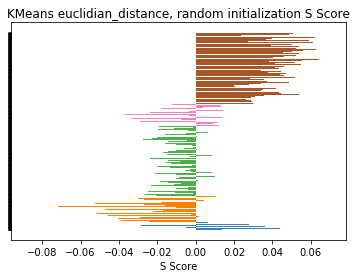

Saved output/bbc/BsaidaTFIDF99_1.png
KMeans euclidian_distance, ++initialization started training
finished training
done in 10 iterations


/home/ec2-user/miniconda3/envs/text-clustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/miniconda3/envs/text-clustering/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 1440x1440 with 0 Axes>

KeyboardInterrupt: 

In [58]:
CENTROIDS = 5
MIN_CENTROIDS = 1
MAX_CENTROIDS = 7

def get_instances_kmeans(X):
    return [
         ('1', 'KMeans euclidian_distance, random initialization', KMeans().with_euclidian_distance().initialize_random(CENTROIDS, X)),
         ('2', 'KMeans euclidian_distance, ++initialization', KMeans().with_euclidian_distance().initialize_plus_plus(CENTROIDS, X)),
         ('3', 'KMeans cosine_similarity, random initialization', KMeans().with_cosin_similarity().initialize_random(CENTROIDS, X)),
         ('4', 'KMeans cosine_similarity, ++initialization', KMeans().with_cosin_similarity().initialize_plus_plus(CENTROIDS, X))
    ]
def get_instances_xmeans(X):
    return [
         ('5', 'XMeans euclidian_distance', XMeans().with_euclidian_distance().set_centroid_estimation_range(MIN_CENTROIDS, MAX_CENTROIDS)),
         ('6', 'XMeans cosine_similarity', XMeans().with_cosin_similarity().set_centroid_estimation_range(MIN_CENTROIDS, MAX_CENTROIDS))
    ]

files = get_files_in_folder('data/bbc')
print(files)
for i, f in enumerate(files):
    print('File', i, 'of', len(files))
    print('-------------------------------', f, '-------------------------------')
    X = read_data(f)
    
    for file_id, desc, instance in get_instances_kmeans(X):
        print(desc, 'started training')
        
        instance, iterations = instance.train(X)
        print('finished training')
        print('done in', str(iterations), 'iterations')
        
        file_name = 'output/bbc/' + f.split('/')[-1].strip('.csv') + '_' + file_id + '.png'
        plot_silhouette(instance, X, desc, file_name)
        print('Saved ' + file_name)
        
    for file_id, desc, instance in get_instances_xmeans(X):
        print(desc, 'started training')
        instance, iterations = instance.train(X)
        print('finished training')
        print('done in', str(iterations), 'iterations')
        
        file_name = 'output/bbc/' + f.split('/')[-1] + '_' + file_id
        plot_silhouette(instance, X, desc, file_name)
        print('Saved ' + file_name)

print('finished')

## Reuters

In [43]:
CENTROIDS = 5
MIN_CENTROIDS = 1
MAX_CENTROIDS = 10

def get_instances_kmeans(X):
    return [
         ('1', 'KMeans euclidian_distance, random initialization', KMeans().with_euclidian_distance().initialize_random(CENTROIDS, X)),
         ('2', 'KMeans euclidian_distance, ++initialization', KMeans().with_euclidian_distance().initialize_plus_plus(CENTROIDS, X)),
         ('3', 'KMeans cosine_similarity, random initialization', KMeans().with_cosin_similarity().initialize_random(CENTROIDS, X)),
         ('4', 'KMeans cosine_similarity, ++initialization', KMeans().with_cosin_similarity().initialize_plus_plus(CENTROIDS, X))
    ]
def get_instances_xmeans(X):
    return [
         ('5', 'XMeans euclidian_distance', XMeans().with_euclidian_distance().set_centroid_estimation_range(MIN_CENTROIDS, MAX_CENTROIDS)),
         ('6', 'XMeans cosine_similarity', XMeans().with_cosin_similarity().set_centroid_estimation_range(MIN_CENTROIDS, MAX_CENTROIDS))
    ]

files = get_files_in_folder('data/reuters')
print(files)
for i, f in enumerate(files):
    print('File', i, 'of', len(files))
    print('-------------------------------', f, '-------------------------------')
    X = read_data(f)
    
    for file_id, desc, instance in get_instances_kmeans(X):
        print(desc, 'started training')
        
        instance, iterations = instance.train(X)
        print('finished training')
        print('done in', str(iterations), 'iterations')
        
        file_name = 'output/reuters/' + f.split('/')[-1].strip('.csv') + '_' + file_id + '.png'
        plot_silhouette(instance, X, desc, file_name)
        print('Saved ' + file_name)
        
    for file_id, desc, instance in get_instances_xmeans(X):
        print(desc, 'started training')
        instance, iterations = instance.train(X)
        print('finished training')
        print('done in', str(iterations), 'iterations')
        
        file_name = 'output/reuters/' + f.split('/')[-1] + '_' + file_id
        plot_silhouette(instance, X, desc, file_name)
        print('Saved ' + file_name)

print('finished')

['data/reuters/RsaidaTFIDF98.csv', 'data/reuters/RsaidaBin98.csv', 'data/reuters/RsaidaBin99.csv', 'data/reuters/RsaidaTFIDF99.csv', 'data/reuters/RsaidaTF98.csv', 'data/reuters/RsaidaTF99.csv']
File 0 of 6
------------------------------- data/reuters/RsaidaTFIDF98.csv -------------------------------


KeyboardInterrupt: 

In [ ]:
# q = read_data('data/reuters/RsaidaTFIDF98.csv')[1925]
np.all(q == 0)
def h(x):
    if np.all(np.array(x)==0) or not np.all(x):
        return np.array(x) + np.nextafter(0, 1)
    return np.array(x)
h(q)